In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import numpy as np
from glob import glob
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from PIL import Image
import torch

### Helper Functions

In [3]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [4]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

In [5]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [6]:
summary_paths = glob(f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/*/*/summary_stats.csv")

df = pd.concat([pd.read_csv(path) for path in summary_paths])
# Calculate mean over all columns that contain 'acc'
df['mean_acc'] = df.filter(like='acc').mean(axis=1)
df

,attribute,neg_class,pos_class,acc_dim_0,acc_dim_1,acc_dim_2,acc_dim_3,acc_dim_4,acc_dim_5,acc_dim_6,acc_dim_7,acc_dim_8,acc_dim_9,acc_dim_10,acc_dim_11,acc_dim_12,acc_dim_13,acc_dim_14,acc_dim_15,mean_acc
0,sleeve_length,Sleeveless,Elbow length,0.993028,0.995020,0.995020,0.996016,0.997012,0.990040,0.998008,0.996016,0.997012,0.992032,0.995020,0.996016,0.992032,0.994024,0.996016,0.996016,0.994895
0,sleeve_length,Extra short,Elbow length,0.984055,0.986333,0.984055,0.995444,0.993166,0.984055,0.997722,0.984055,0.981777,0.990888,0.988610,0.981777,0.990888,0.995444,0.993166,0.984055,0.988468
0,sleeve_length,34 length,Mixed,0.957831,0.969880,0.977912,0.959839,0.961847,0.971888,0.963855,0.949799,0.969880,0.945783,0.959839,0.963855,0.963855,0.975904,0.971888,0.967871,0.964483
0,sleeve_length,Mixed,Extra long,0.941441,0.959459,0.954955,0.936937,0.954955,0.941441,0.959459,0.923423,0.905405,0.914414,0.918919,0.900901,0.932432,0.945946,0.932432,0.936937,0.934966
0,sleeve_length,Extra short,Strapless,0.944649,0.952030,0.963100,0.974170,0.970480,0.970480,0.985240,0.974170,0.944649,0.959410,0.963100,0.937269,0.966790,0.944649,0.948339,0.959410,0.959871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,color,orange,purple,0.891525,0.911864,0.908475,0.894915,0.888136,0.898305,0.877966,0.905085,0.861017,0.901695,0.891525,0.922034,0.908475,0.901695,0.942373,0.969492,0.904661
0,color,black,yellow,0.997196,0.994393,0.994393,0.992523,0.997196,0.994393,0.996262,0.992523,0.994393,0.992523,0.995327,0.996262,0.996262,0.995327,0.996262,0.998131,0.995210
0,color,brown,grey,0.879464,0.870536,0.863095,0.845238,0.840774,0.843750,0.857143,0.852679,0.869048,0.849702,0.864583,0.870536,0.885417,0.858631,0.885417,0.909226,0.865327
0,color,blue,white,0.978454,0.979721,0.977186,0.973384,0.978454,0.980989,0.977186,0.980989,0.980989,0.982256,0.972117,0.968314,0.983523,0.979721,0.977186,0.984791,0.978454


In [7]:
# Print the worst performing boundaries for each attribute
for attribute in df.attribute.unique():
    print(attribute)
    print(df[df.attribute == attribute][['neg_class', 'pos_class', 'mean_acc']].sort_values('mean_acc', ascending=True).head(5))

sleeve_length
   neg_class              pos_class  mean_acc
0      Mixed  Sleeveless, strapless  0.763235
0  Strapless  Sleeveless, strapless  0.768601
0      Mixed              Strapless  0.820153
0      Short           Elbow length  0.848907
0       Long             Extra long  0.854763
category
      neg_class       pos_class  mean_acc
0   Shift dress    Jersey dress  0.773850
0  Jersey dress       Day dress  0.799408
0  Jersey dress  Cocktail dress  0.804768
0  Jersey dress    Jumper dress  0.809028
0   Shift dress  Cocktail dress  0.819587
color
  neg_class pos_class  mean_acc
0      gold    silver  0.822917
0    orange    yellow  0.840376
0      grey    silver  0.849231
0     brown    purple  0.852223
0      grey     green  0.860168


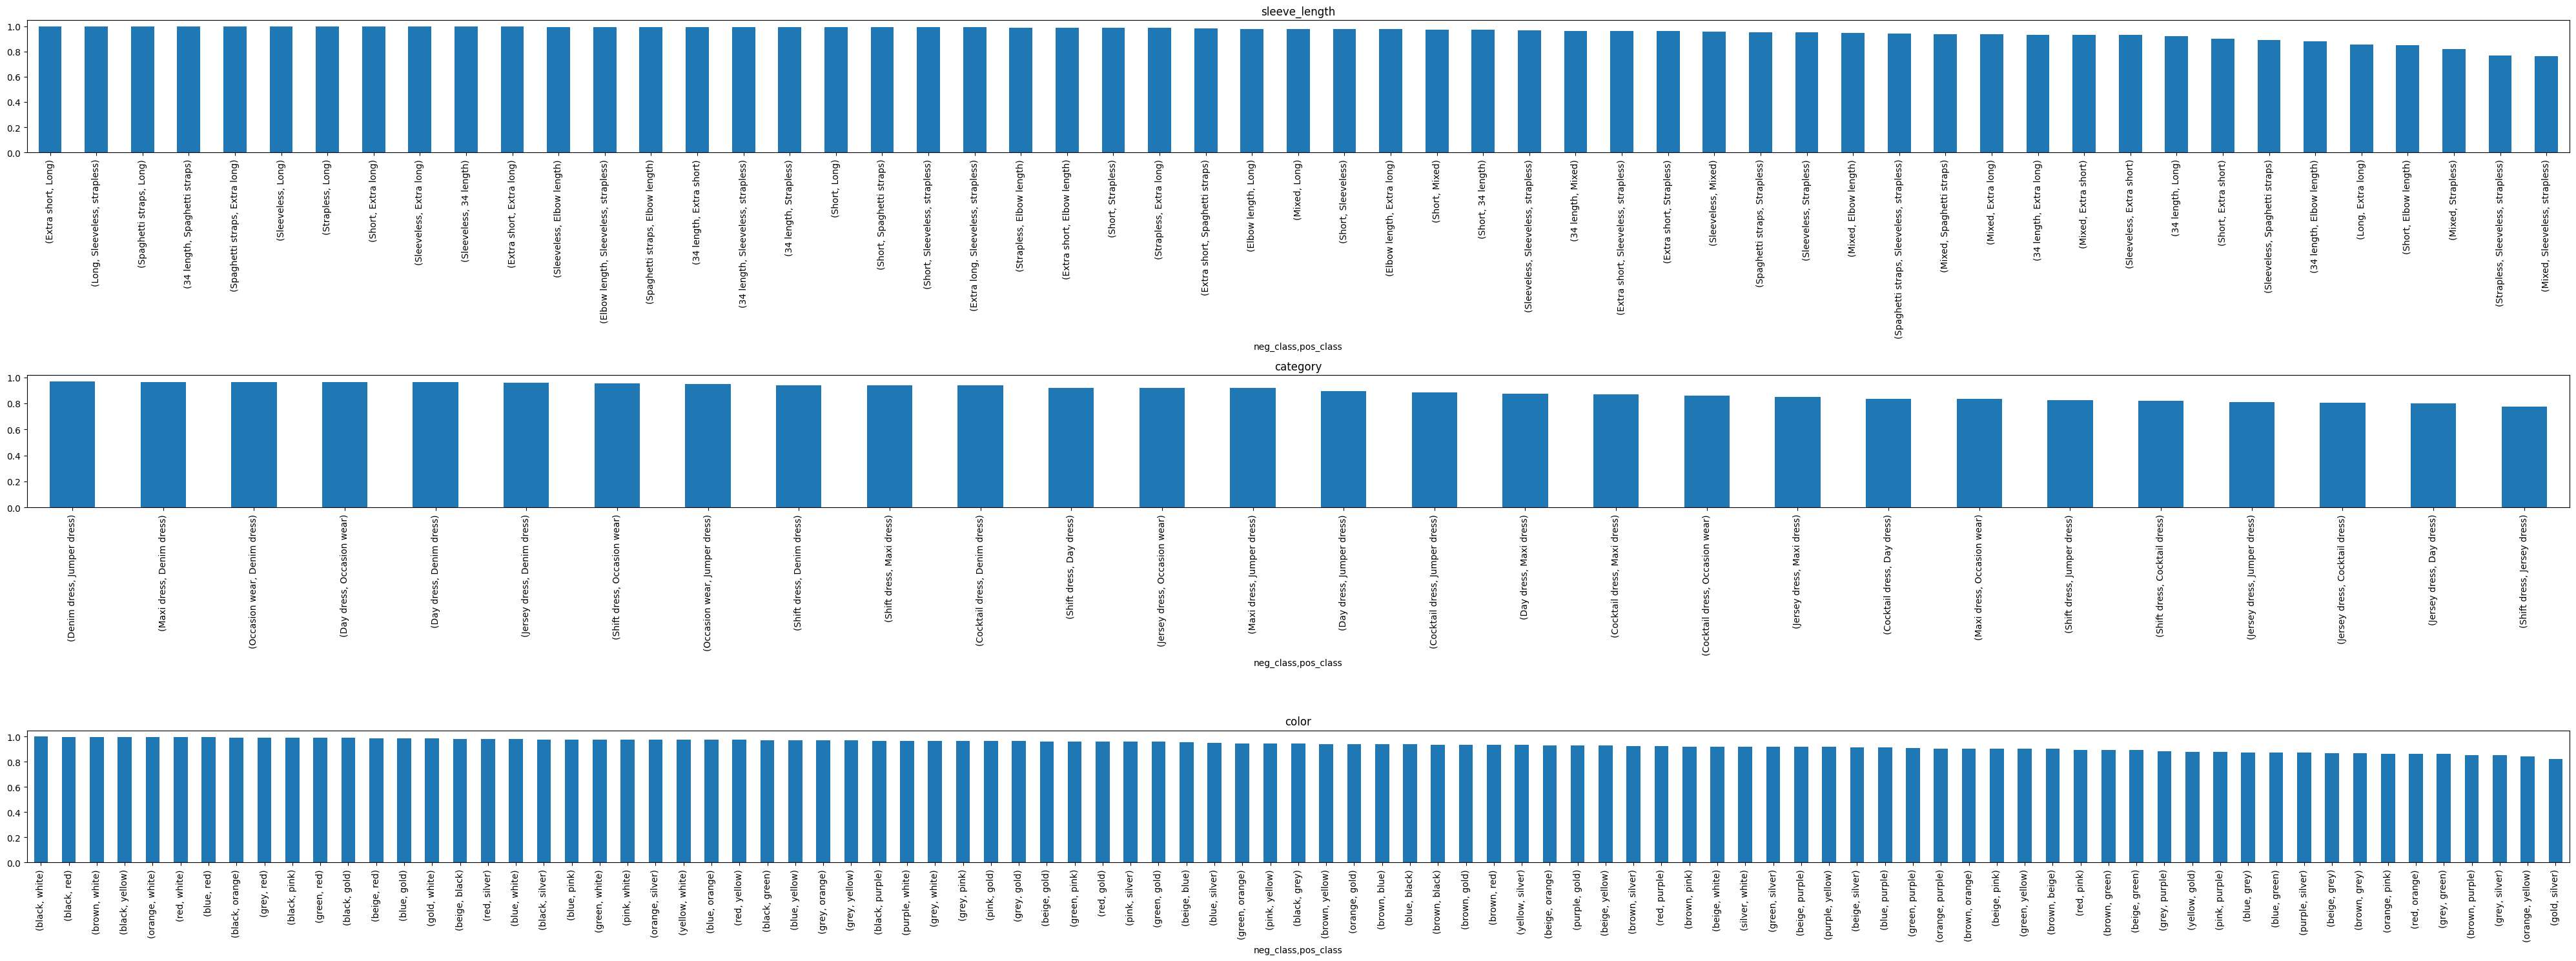

In [8]:
fig, ax = plt.subplots(3,1, figsize = (40,15))
for i, attribute in enumerate(df.attribute.unique()):
    df[df.attribute == attribute].set_index(['neg_class', 'pos_class']).mean_acc.sort_values(ascending=False).plot(kind = 'bar', ax = ax[i])
    ax[i].set_title(attribute)

fig.tight_layout()
plt.show()

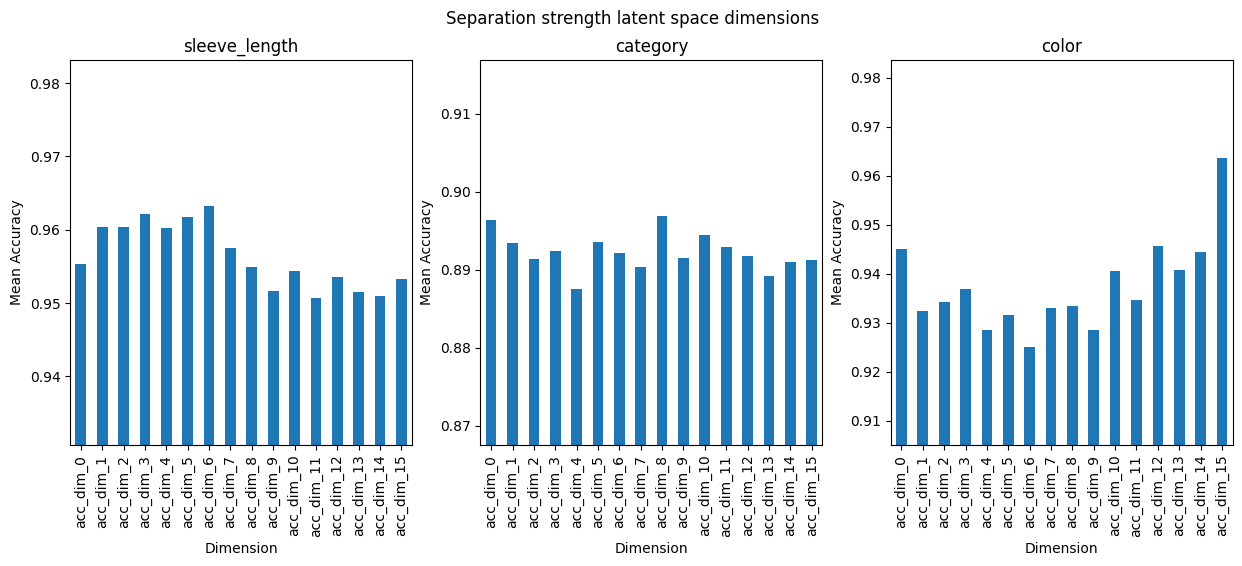

In [9]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, attribute in enumerate(df.attribute.unique()):
    means = df[df.attribute == attribute].filter(like='acc_').mean(axis=0)
    means.plot(kind='bar', ax = ax[i])
    ax[i].set_ylim(means.min()-0.02,means.max()+0.02)
    ax[i].set_ylabel('Mean Accuracy')
    ax[i].set_xlabel('Dimension')
    ax[i].set_title(f"{attribute}")

fig.suptitle("Separation strength latent space dimensions")
plt.show()

### Visualize Sample based on Distance to the decision boundary
- Similar Analysis as done in the InterFaceGAN Paper
- As i am operating in $\mathcal{W}+$ Space and not in the $\mathcal{Z}$ Space like the authors, I calculate the distance to the decision boundary for all dimensions and sum them up to get the final distance.
- The dresses with the largest positive/negative distance should be the most clear examples of the positive/negative class
- The samples with the smallest absolute distance should be difficult to distinguish between the two classes

In [10]:
def plot_distances(attribute, att1, att2, n=3):

    # Load all latents
    latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

    try:
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{attribute}/{att1}_{att2}/"
        boundary = np.load(f"{boundaries_base_dir}boundary_dim{0}.npy")
    except:
        att1, att2 = att2, att1
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{attribute}/{att1}_{att2}/"

    print(f'Calculating distances to decision boundary between {att1} (negative class) and {att2} (positive class)')

    distances = {}
    for sku in tqdm(latents.keys(), leave = False):
        distances_sku = []
        for dim in range(16):
            latent = latents[sku][:, dim, :]
            boundary = np.load(f"{boundaries_base_dir}boundary_dim{dim}.npy")
            boundary = torch.tensor(boundary)
            distance =  latent.matmul(boundary.T).item()
            distances_sku.append(distance)
        distances[sku] = distances_sku

    total_distances = pd.Series({k:np.sum(v) for k,v in distances.items()})

    largest_pos = total_distances.nlargest(n).index.to_list()
    largest_neg = total_distances.nsmallest(n).index.to_list()
    closest = total_distances.abs().nsmallest(n).index.to_list()

    print(f'Creating the plot using {n} examples')

    # Visualize the closest and furthest latents
    fig, ax = plt.subplots(3, n, figsize=(4*n,4*n))
    for i, sku in enumerate(largest_pos):
        img = generate_from_latent(latents[sku])
        ax[0, i].imshow(img)
        ax[0, i].set_title(f"{sku} | {total_distances[sku]:.2f}")
        ax[0, i].axis('off')

        ax[0, 0].set_ylabel('Largest positive distances')

    for i, sku in enumerate(closest):
        img = generate_from_latent(latents[sku])
        ax[1, i].imshow(img)
        ax[1, i].set_title(f"{sku} | {total_distances[sku]:.2f}")
        ax[1, i].axis('off')

    for i, sku in enumerate(largest_neg):
        img = generate_from_latent(latents[sku])
        ax[2, i].imshow(img)
        ax[2, i].set_title(f"{sku} | {total_distances[sku]:.2f}")
        ax[2, i].axis('off')

    plt.show()

Calculating distances to decision boundary between Day dress (negative class) and Occasion wear (positive class)


Creating the plot using 3 examples


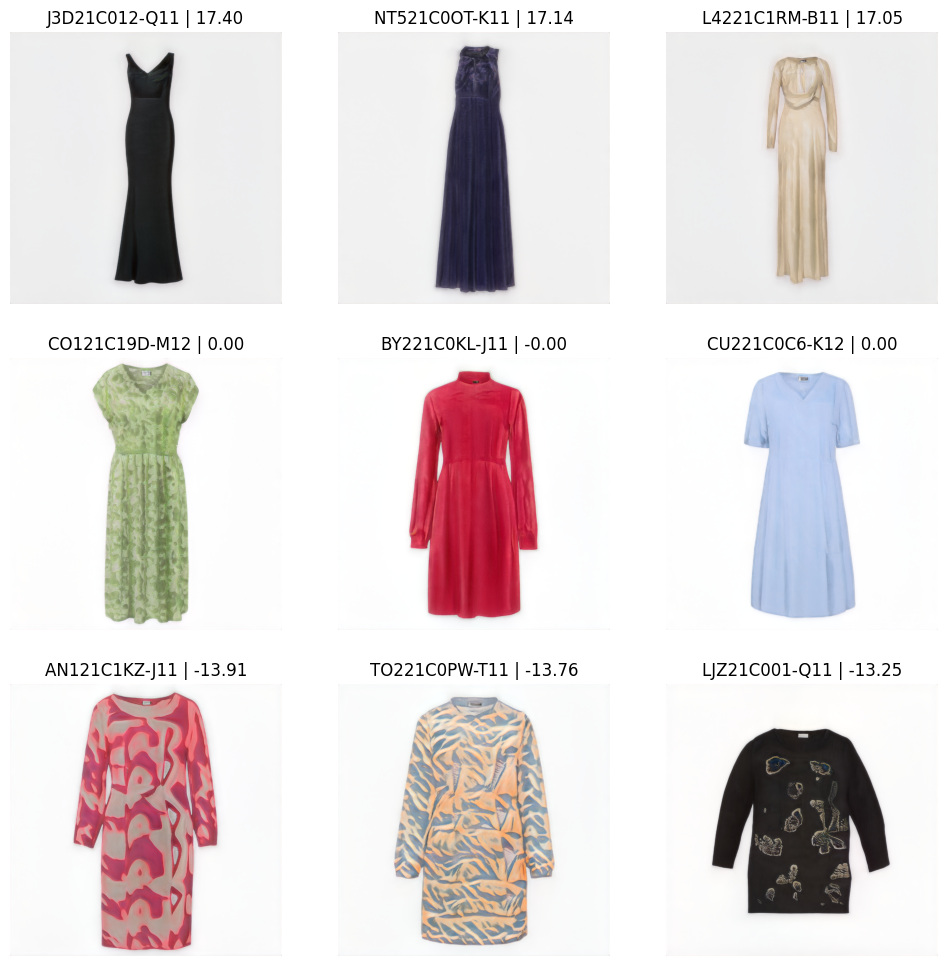

In [11]:
attribute = 'category'
att1 = 'Day dress'
att2 = 'Occasion wear'
n = 3

plot_distances(attribute, att1, att2, n)

Calculating distances to decision boundary between blue (negative class) and red (positive class)


Creating the plot using 3 examples


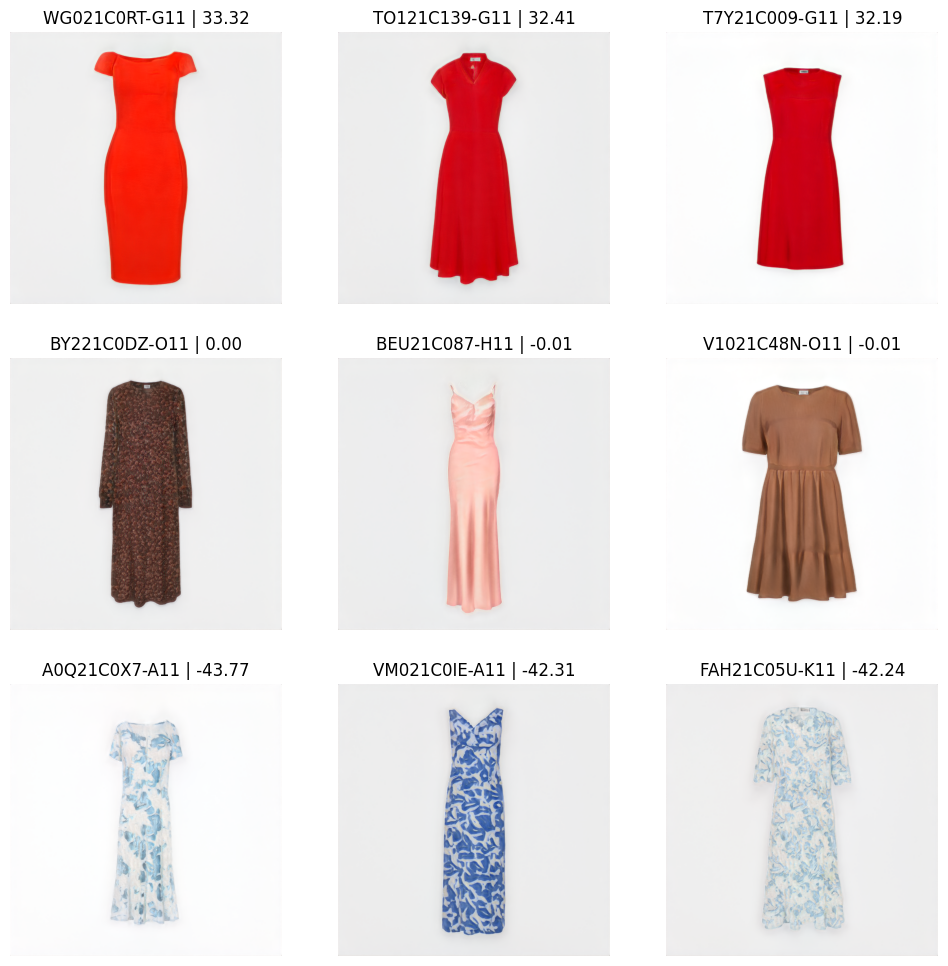

In [12]:
attribute = 'color'
att1 = 'blue'
att2 = 'red'
n = 3

plot_distances(attribute, att1, att2, n)

Calculating distances to decision boundary between Sleeveless (negative class) and Long (positive class)


Creating the plot using 3 examples


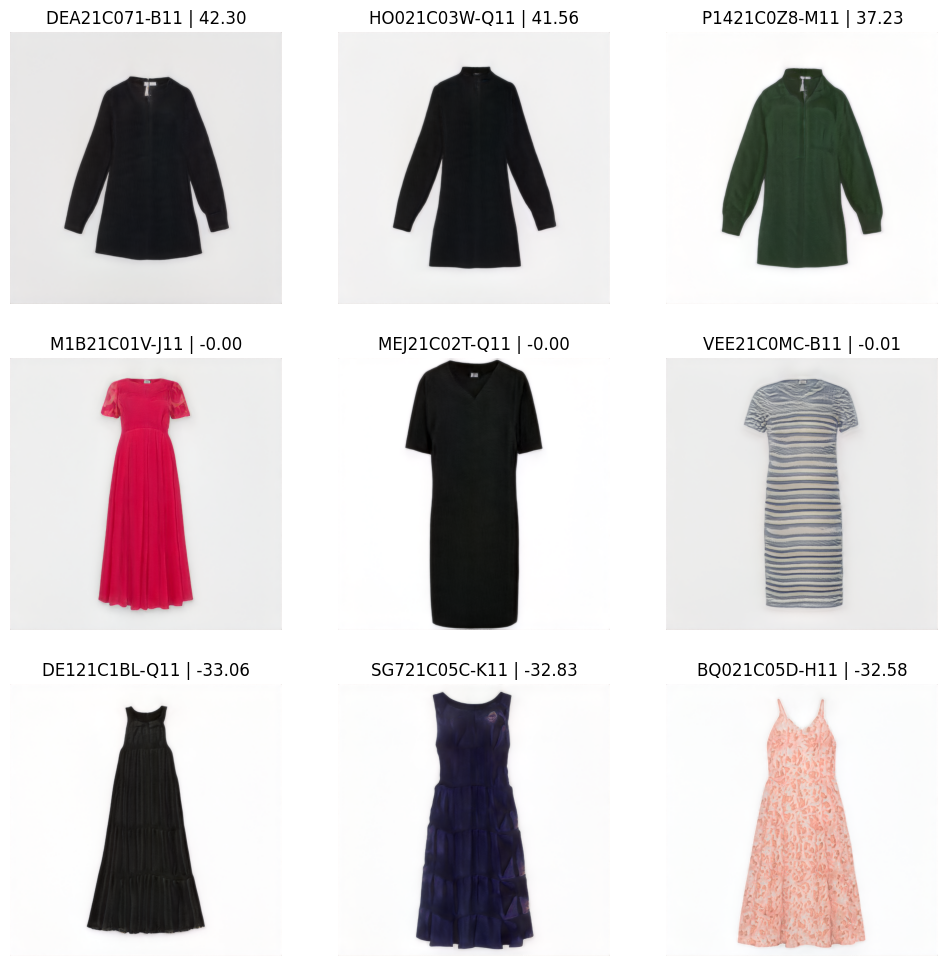

In [13]:
attribute = 'sleeve_length'
att1 = 'Long'
att2 = 'Sleeveless'
n = 3

plot_distances(attribute, att1, att2, n)